<a href="https://colab.research.google.com/github/Ddkaba/IAD_Lab_3/blob/main/IAD_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №3

Михайлов Даниил, Спицов Андрей

In [1]:
# Импорты
import requests
import zipfile
import os
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers

In [3]:
# Скачивание и распаковка архива
url = 'https://www.kaggle.com/api/v1/datasets/download/alxmamaev/flowers-recognition'
zip_path = 'flowers-recognition.zip'
extract_path = '.'

# Скачивание
print('Скачивание архива...')
response = requests.get(url, allow_redirects=True)
with open(zip_path, 'wb') as f:
    f.write(response.content)
print(f'Архив скачан: {zip_path}')

# Распаковка
print('Распаковка архива...')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print('Архив распакован')

# Путь к данным и показать классы
data_path = 'flowers'
print(f'\nПуть к данным: {data_path}')
print('Классы цветов:')
for flower_class in os.listdir(data_path):
    class_path = os.path.join(data_path, flower_class)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f'  - {flower_class}: {count} изображений')


Скачивание архива...
Архив скачан: flowers-recognition.zip
Распаковка архива...
Архив распакован

Путь к данным: flowers
Классы цветов:
  - rose: 784 изображений
  - tulip: 984 изображений
  - sunflower: 733 изображений
  - dandelion: 1052 изображений
  - daisy: 764 изображений


Количество классов: 5
Классы и количество изображений:
  - rose: 784 изображений
  - tulip: 984 изображений
  - sunflower: 733 изображений
  - dandelion: 1052 изображений
  - daisy: 764 изображений

Размеры изображений (первые 5 изображений каждого класса):

Класс: rose
  - 7376471712_e1be793f94.jpg: 150x150 пикселей
  - 26723815164_d03d4d69cb_n.jpg: 150x150 пикселей
  - 7474126688_5f888ace5b_n.jpg: 150x150 пикселей
  - 7251352826_69b62cba2c_m.jpg: 150x150 пикселей
  - 5349865018_99cd7f985a_n.jpg: 150x150 пикселей

Класс: tulip
  - 12873145295_438b8197a7_n.jpg: 150x150 пикселей
  - 14671196461_b725727229_m.jpg: 150x150 пикселей
  - 15096307668_589504b03f_n.jpg: 150x150 пикселей
  - 3446285408_4be9c0fded_m.jpg: 150x150 пикселей
  - 8713394070_b24561b0a9.jpg: 150x150 пикселей

Класс: sunflower
  - 3749091071_c146b33c74_n.jpg: 150x150 пикселей
  - 2894191705_a1d2d80c80.jpg: 150x150 пикселей
  - 34571252122_b3b1f45fac_n.jpg: 150x150 пикселей
  - 19508264965_d1dfb565ea_n.jpg: 150x150 пиксел

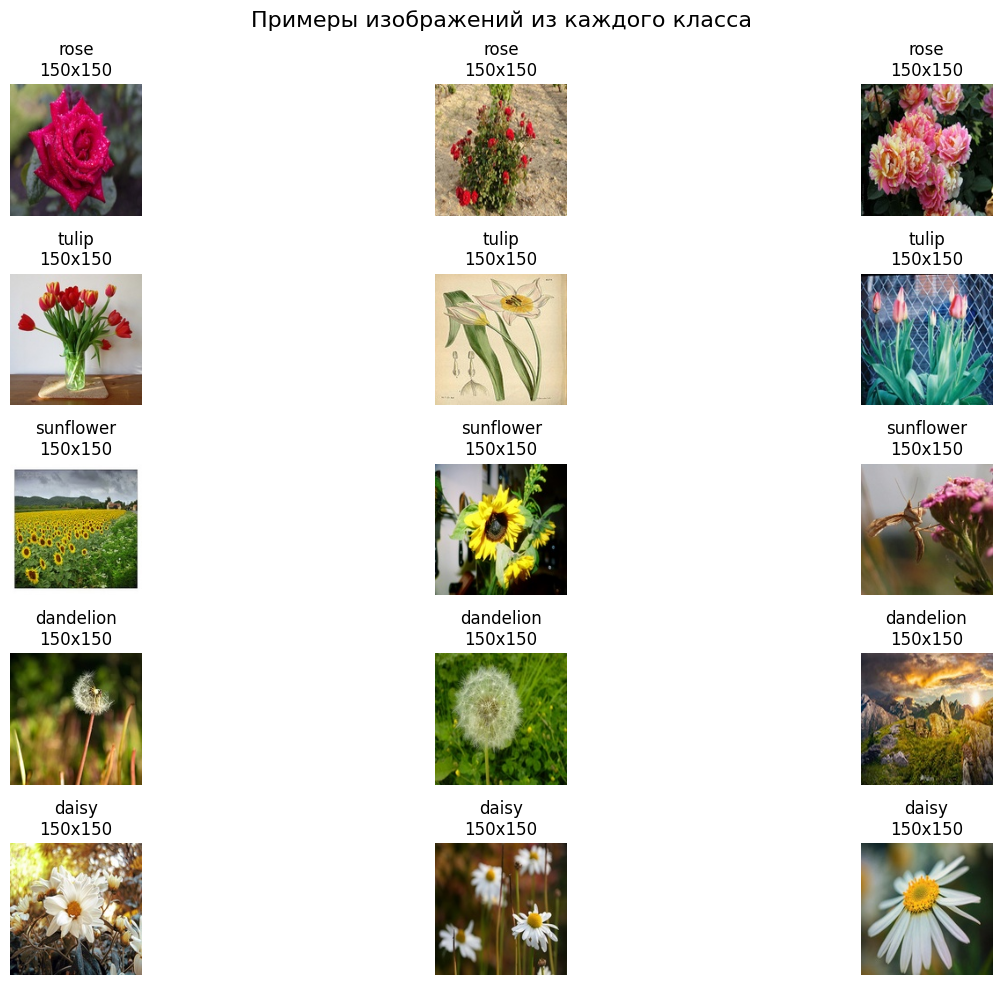

In [10]:
data_path = 'flowers'
# Получение списка классов
classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
num_classes = len(classes)

# Подсчёт количества изображений в каждом классе
class_counts = {}
for flower_class in classes:
    class_dir = os.path.join(data_path, flower_class)
    num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[flower_class] = num_images

# Вывод информации
print(f"Количество классов: {num_classes}")
print("Классы и количество изображений:")
for flower_class, count in class_counts.items():
    print(f"  - {flower_class}: {count} изображений")

print("\nРазмеры изображений (первые 5 изображений каждого класса):")
for flower_class in classes:
    class_dir = os.path.join(data_path, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
    print(f"\nКласс: {flower_class}")
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            print(f"  - {img_name}: {width}x{height} пикселей")

# Визуализация примеров изображений
plt.figure(figsize=(15, 10))
for i, flower_class in enumerate(classes):
    class_dir = os.path.join(data_path, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]  # Первые 3 изображения
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            plt.subplot(num_classes, 3, i * 3 + j + 1)
            plt.imshow(img)
            plt.title(f"{flower_class}\n{img.size[0]}x{img.size[1]}")
            plt.axis('off')
plt.suptitle("Примеры изображений из каждого класса", fontsize=16)
plt.tight_layout()
plt.show()


In [4]:
# Параметры для преобразования
target_size = (150, 150)  # Целевой размер всех изображений

print(f'Целевой размер изображений: {target_size[0]}x{target_size[1]}')


Целевой размер изображений: 150x150


In [5]:
# Функция для преобразования изображения
def preprocess_image(img_path, target_size):
    """
    1. Читает JPEG файл
    2. Декодирует в RGB
    3. Изменяет размер до target_size
    4. Возвращает PIL изображение
    """
    img = Image.open(img_path)
    # Конвертация в RGB (на случай RGBA или grayscale)
    img = img.convert('RGB')
    # Изменение размера
    img = img.resize(target_size, Image.LANCZOS)
    return img

print('Функция преобразования создана')


Функция преобразования создана


In [7]:
# Преобразование всех изображений в исходной папке
original_dataset_dir = 'flowers'

print('Начало преобразования изображений...\n')

classes = [d for d in os.listdir(original_dataset_dir)
           if os.path.isdir(os.path.join(original_dataset_dir, d))]

total_processed = 0
for flower_class in classes:
    class_dir = os.path.join(original_dataset_dir, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f'Обработка класса "{flower_class}": {len(images)} изображений...')

    for img_name in images:
        img_path = os.path.join(class_dir, img_name)

        try:
            # Преобразование
            img = preprocess_image(img_path, target_size)
            # Сохранение обратно
            img.save(img_path, 'JPEG', quality=95)
            total_processed += 1
        except Exception as e:
            print(f'  Ошибка при обработке {img_name}: {e}')

    print(f'  ✓ Обработано: {len(images)} изображений')

print(f'\nВсего преобразовано: {total_processed} изображений')
print(f'Все изображения теперь имеют размер {target_size[0]}x{target_size[1]} пикселей')


Начало преобразования изображений...

Обработка класса "rose": 784 изображений...
  ✓ Обработано: 784 изображений
Обработка класса "tulip": 984 изображений...
  ✓ Обработано: 984 изображений
Обработка класса "sunflower": 733 изображений...
  ✓ Обработано: 733 изображений
Обработка класса "dandelion": 1052 изображений...
  ✓ Обработано: 1052 изображений
Обработка класса "daisy": 764 изображений...
  ✓ Обработано: 764 изображений

Всего преобразовано: 4317 изображений
Все изображения теперь имеют размер 150x150 пикселей


In [ ]:
# Проверка: показать несколько преобразованных изображений
print('Примеры преобразованных изображений:\n')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

idx = 0
for flower_class in classes[:2]:  # Первые 2 класса
    class_dir = os.path.join(original_dataset_dir, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:4]

    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].set_title(f'{flower_class}\n{img.size[0]}x{img.size[1]} px')
        axes[idx].axis('off')
        idx += 1

plt.tight_layout()
plt.show()


In [ ]:
# Создание структуры папок для train/validation/test
original_dataset_dir = 'flowers/flowers'
base_dir = 'flowers_dataset'
os.makedirs(base_dir, exist_ok=True)

# Создание основных директорий
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Получить список всех классов
classes = [d for d in os.listdir(original_dataset_dir)
           if os.path.isdir(os.path.join(original_dataset_dir, d))]

print(f'Найдено классов: {len(classes)}')
print(f'Классы: {classes}')


In [ ]:
# Создание поддиректорий для каждого класса
for flower_class in classes:
    os.makedirs(os.path.join(train_dir, flower_class), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, flower_class), exist_ok=True)
    os.makedirs(os.path.join(test_dir, flower_class), exist_ok=True)

print('Структура папок создана')


In [ ]:
# Копирование изображений в соответствующие папки
# Разделение: первые 60% - train, следующие 20% - validation, последние 20% - test

for flower_class in classes:
    src_dir = os.path.join(original_dataset_dir, flower_class)
    fnames = os.listdir(src_dir)

    total = len(fnames)
    train_count = int(0.6 * total)
    val_count = int(0.2 * total)

    # Train
    train_fnames = fnames[:train_count]
    for fname in train_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(train_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    # Validation
    val_fnames = fnames[train_count:train_count + val_count]
    for fname in val_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(validation_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    # Test
    test_fnames = fnames[train_count + val_count:]
    for fname in test_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(test_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    print(f'{flower_class}: train={len(train_fnames)}, val={len(val_fnames)}, test={len(test_fnames)}')


In [ ]:
# Вывод структуры папок с размерами
def get_dir_size(path):
    """Вычисляет размер папки в МБ"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp):
                total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Конвертация в МБ

print('Структура папок с размерами:\n')
print(f'{base_dir}/ - {get_dir_size(base_dir):.2f} МБ')

for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    split_size = get_dir_size(split_dir)
    print(f'  {split}/ - {split_size:.2f} МБ')

    for flower_class in sorted(classes):
        class_dir = os.path.join(split_dir, flower_class)
        class_size = get_dir_size(class_dir)
        count = len(os.listdir(class_dir))
        print(f'    {flower_class}/ - {class_size:.2f} МБ ({count} изображений)')


In [ ]:
# Параметры для создания тензоров
img_height = 150
img_width = 150
batch_size = 32

print(f'Параметры преобразования в тензоры:')
print(f'  Размер: {img_height}x{img_width}')
print(f'  Размер батча: {batch_size}')


In [ ]:
# Создание датасетов с использованием image_dataset_from_directory
# Эта функция автоматически:
# 1) Составляет список подкаталогов (классов)
# 2) Индексирует файлы изображений в каждом подкаталоге
# 3) Создает tf.data.Dataset
# 4) Читает файлы JPEG
# 5) Декодирует в RGB
# 6) Преобразует в тензоры
# 7) Приводит к общему размеру
# 8) Упаковывает в батчи

# Обучающая выборка
train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Валидационная выборка
validation_dataset = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Тестовая выборка
test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False  # Не перемешиваем тест для корректной оценки
)

print('\n✓ Датасеты успешно созданы с помощью image_dataset_from_directory')


In [ ]:
# Нормализация значений пикселей [0, 255] -> [0, 1]
# Создаем слой нормализации
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к датасетам
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

print('Нормализация применена: [0, 255] -> [0, 1]')


In [ ]:
# Аугментация данных для обучающей выборки
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# Применяем аугментацию только к обучающей выборке
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

print('Аугментация данных добавлена к обучающей выборке')


In [ ]:
# Оптимизация производительности
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Оптимизация датасетов завершена (prefetch)')


In [ ]:
# Проверка: получение и визуализация батча тензоров
sample_batch, sample_labels = next(iter(train_dataset))

print('Проверка преобразования в тензоры:\n')
print(f'Форма батча изображений: {sample_batch.shape}')
print(f'  - Батч содержит {sample_batch.shape[0]} изображений')
print(f'  - Каждое изображение: {sample_batch.shape[1]}x{sample_batch.shape[2]} пикселей')
print(f'  - Количество каналов (RGB): {sample_batch.shape[3]}')
print(f'\nФорма батча меток: {sample_labels.shape}')
print(f'  - One-hot encoding для {sample_labels.shape[1]} классов')
print(f'\nДиапазон значений пикселей в тензоре: [{sample_batch.numpy().min():.3f}, {sample_batch.numpy().max():.3f}]')
print(f'Тип данных: {sample_batch.dtype}')

# Получение имен классов
class_names = train_dataset.class_names if hasattr(train_dataset, 'class_names') else sorted(os.listdir(train_dir))
print(f'\nКлассы: {class_names}')
print(f'\n✓ Изображения успешно преобразованы в тензоры с вещественными числами [0, 1]')


In [ ]:
# Визуализация батча преобразованных изображений
plt.figure(figsize=(15, 10))

# Получаем классы из каталога
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

for i in range(12):
    plt.subplot(3, 4, i + 1)
    # Клиппинг значений на случай если аугментация дала значения вне [0, 1]
    img_to_show = np.clip(sample_batch[i].numpy(), 0, 1)
    plt.imshow(img_to_show)

    # Получить название класса
    class_idx = np.argmax(sample_labels[i])
    class_name = class_names[class_idx]

    plt.title(f'{class_name}')
    plt.axis('off')

plt.suptitle('Примеры изображений из батча (тензоры нормализованы [0, 1])', fontsize=14)
plt.tight_layout()
plt.show()

print('\nИзображения готовы к подаче в нейронную сеть!')


In [ ]:
# ЗАДАНИЕ 1: Построение сверточной нейронной сети
# Архитектура: Conv2D + MaxPooling + Dense классификатор

num_classes = 5  # Количество классов цветов
l2_reg = 0.001  # Коэффициент L2 регуляризации

model = models.Sequential([
    # Входной слой
    layers.Input(shape=(150, 150, 3)),

    # Блок 1: Conv2D + MaxPooling
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 2: Conv2D + MaxPooling
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 3: Conv2D + MaxPooling
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 4: Conv2D + MaxPooling
    layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 5: Conv2D + MaxPooling
    layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Flatten для преобразования карт признаков в вектор
    layers.Flatten(),

    # Полносвязный классификатор (не менее 2 слоев)
    # Комбинируем Dropout + L2 регуляризацию для борьбы с переобучением
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),

    # Выходной слой для 5 классов
    layers.Dense(num_classes, activation='softmax')
])

# Просмотр архитектуры
model.summary()


In [ ]:
# Компиляция модели
model.compile(
    loss='categorical_crossentropy',  # Для многоклассовой классификации
    optimizer='adam',  # Adam оптимизатор (можно заменить на 'rmsprop')
    metrics=['accuracy']
)

print('✓ Модель скомпилирована')
print(f'Оптимизатор: Adam')
print(f'Функция потерь: categorical_crossentropy')
print(f'Метрики: accuracy')


In [ ]:
# Обучение модели с валидацией
epochs = 30

print(f'Начало обучения на {epochs} эпох...\n')

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1
)

print('\n✓ Обучение завершено')


In [ ]:
# Построение графиков точности и потерь
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График точности
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Точность модели (Accuracy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Эпоха', fontsize=12)
axes[0].set_ylabel('Точность', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# График потерь
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Потери модели (Loss)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Эпоха', fontsize=12)
axes[1].set_ylabel('Потери', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод финальных метрик
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'\nФинальные метрики:')
print(f'Train Accuracy: {final_train_acc:.4f}')
print(f'Validation Accuracy: {final_val_acc:.4f}')
print(f'Train Loss: {final_train_loss:.4f}')
print(f'Validation Loss: {final_val_loss:.4f}')


In [ ]:
# Оценка на тестовой выборке
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f'\n{"="*50}')
print(f'РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:')
print(f'{"="*50}')
print(f'Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'Test Loss: {test_loss:.4f}')
print(f'{"="*50}')


In [ ]:
# Сохранение модели (в современном формате Keras)
model.save('model_cnn_custom.keras')
print('✓ Модель сохранена: model_cnn_custom.keras')


## ЗАДАНИЕ 2 (Альтернативный подход): Извлечение признаков из предобученной модели

**Подход из лекций:** Извлечь признаки через сверточную основу EfficientNetB1 один раз, сохранить в NumPy массивы, затем обучить простой Dense классификатор на готовых признаках.


In [ ]:
# Создание сверточной основы для извлечения признаков
conv_base = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

print('✓ Сверточная основа EfficientNetB1 загружена')
print(f'Форма выхода conv_base: {conv_base.output_shape}')


✓ Сверточная основа EfficientNetB1 загружена
Форма выхода conv_base: (None, 5, 5, 1280)


In [ ]:
# Функция для извлечения признаков из датасета
from tensorflow.keras.applications.efficientnet import preprocess_input

def extract_features(dataset, sample_count):
    """
    Извлекает признаки из датасета с помощью conv_base
    """
    features_list = []
    labels_list = []

    samples_processed = 0

    for images_batch, labels_batch in dataset:
        # Предобработка для EfficientNet
        preprocessed = preprocess_input(images_batch.numpy() * 255.0)

        # Извлечение признаков
        features_batch = conv_base.predict(preprocessed, verbose=0)

        features_list.append(features_batch)
        labels_list.append(labels_batch.numpy())

        samples_processed += images_batch.shape[0]
        if samples_processed >= sample_count:
            break

    features = np.concatenate(features_list, axis=0)[:sample_count]
    labels = np.concatenate(labels_list, axis=0)[:sample_count]

    return features, labels

print('✓ Функция извлечения признаков создана')


✓ Функция извлечения признаков создана


In [ ]:
# Извлечение признаков для всех выборок
print('Извлечение признаков из датасетов...\n')

# Подсчет количества образцов
train_samples = sum([1 for _ in train_dataset.unbatch()])
val_samples = sum([1 for _ in validation_dataset.unbatch()])
test_samples = sum([1 for _ in test_dataset.unbatch()])

print(f'Train: {train_samples} образцов')
print(f'Validation: {val_samples} образцов')
print(f'Test: {test_samples} образцов\n')

print('Извлечение признаков из train...')
train_features, train_labels = extract_features(train_dataset, train_samples)
print(f'✓ Train features: {train_features.shape}')

print('Извлечение признаков из validation...')
val_features, val_labels = extract_features(validation_dataset, val_samples)
print(f'✓ Validation features: {val_features.shape}')

print('Извлечение признаков из test...')
test_features, test_labels = extract_features(test_dataset, test_samples)
print(f'✓ Test features: {test_features.shape}')

print('\n✓ Все признаки извлечены и сохранены в NumPy массивы')


Извлечение признаков из датасетов...

Train: 2588 образцов
Validation: 860 образцов
Test: 869 образцов

Извлечение признаков из train...
✓ Train features: (2588, 5, 5, 1280)
Извлечение признаков из validation...
✓ Validation features: (860, 5, 5, 1280)
Извлечение признаков из test...
✓ Test features: (869, 5, 5, 1280)

✓ Все признаки извлечены и сохранены в NumPy массивы


In [ ]:
# Flatten признаков для полносвязной сети
train_features_flat = train_features.reshape((train_features.shape[0], -1))
val_features_flat = val_features.reshape((val_features.shape[0], -1))
test_features_flat = test_features.reshape((test_features.shape[0], -1))

print(f'Форма после flatten:')
print(f'Train: {train_features_flat.shape}')
print(f'Validation: {val_features_flat.shape}')
print(f'Test: {test_features_flat.shape}')


Форма после flatten:
Train: (2588, 32000)
Validation: (860, 32000)
Test: (869, 32000)


In [ ]:
# Построение полносвязного классификатора для готовых признаков
feature_input_shape = train_features_flat.shape[1]

model_features = models.Sequential([
    layers.Input(shape=(feature_input_shape,)),

    # Полносвязный классификатор с регуляризацией
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    # Выходной слой
    layers.Dense(5, activation='softmax')
])

model_features.summary()

print(f'\n✓ Полносвязный классификатор построен')


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │     8,192,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,225,797 (31.38 MB)

 Trainable params: 8,225,797 (31.38 MB)

 Non-trainable params: 0 (0.00 B)


✓ Полносвязный классификатор построен


In [ ]:
# Компиляция модели
from tensorflow.keras.optimizers import Adam

model_features.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('✓ Модель скомпилирована')


✓ Модель скомпилирована


In [ ]:
# Обучение на извлеченных признаках с callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs_features = 80

# Настройка callbacks (как в лекциях)
callbacks = [
    ModelCheckpoint(
        filepath='best_model_efficientnetb1_features.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        verbose=1,
        min_lr=1e-7
    )
]

print(f'Обучение классификатора на готовых признаках ({epochs_features} эпох)')
print('Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\n')

history_features = model_features.fit(
    train_features_flat, train_labels,
    validation_data=(val_features_flat, val_labels),
    epochs=epochs_features,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print('\n✓ Обучение завершено')


Обучение классификатора на готовых признаках (80 эпох)
Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Epoch 1/80
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4206 - loss: 3.4944
Epoch 1: val_loss improved from inf to 1.52346, saving model to best_model_efficientnetb1_features.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.4216 - loss: 3.4857 - val_accuracy: 0.7849 - val_loss: 1.5235 - learning_rate: 0.0010
Epoch 2/80
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6511 - loss: 2.0009
Epoch 2: val_loss improved from 1.52346 to 1.40523, saving model to best_model_efficientnetb1_features.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.6512 - loss: 2.0005 - val_accuracy: 0.8337 - val_loss: 1.4052 - learning_rate: 0.0010
Epoch 3/80
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7202 - loss: 1.7929
Epoch 3: val_loss did not improve from 1.40523
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.7202 - loss: 1.7926 - val_a

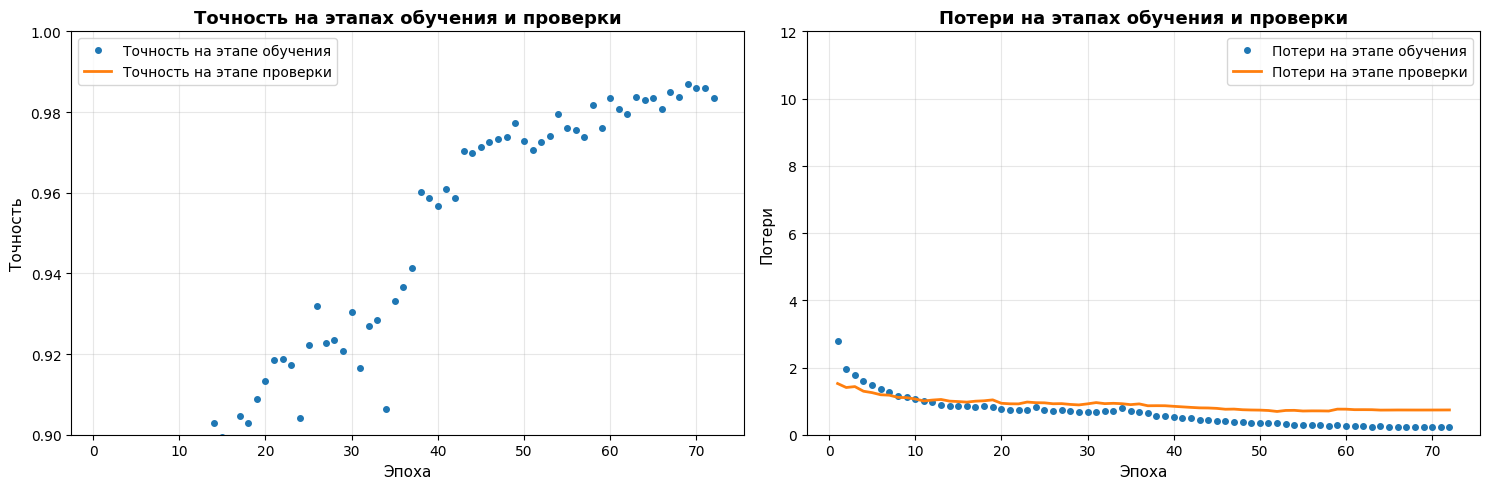


Финальные метрики:
Train Accuracy: 0.9834 (98.34%)
Validation Accuracy: 0.8767 (87.67%)
Train Loss: 0.2316
Validation Loss: 0.7372


In [ ]:
# Построение графиков (в стиле лекций)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history_features.history['accuracy']) + 1)

# График точности
axes[0].plot(epochs_range, history_features.history['accuracy'], 'o',
             label='Точность на этапе обучения', markersize=4)
axes[0].plot(epochs_range, history_features.history['val_accuracy'], '-',
             label='Точность на этапе проверки', linewidth=2)
axes[0].set_title('Точность на этапах обучения и проверки', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Эпоха', fontsize=11)
axes[0].set_ylabel('Точность', fontsize=11)
axes[0].set_ylim([0.9, 1.0])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# График потерь
axes[1].plot(epochs_range, history_features.history['loss'], 'o',
             label='Потери на этапе обучения', markersize=4)
axes[1].plot(epochs_range, history_features.history['val_loss'], '-',
             label='Потери на этапе проверки', linewidth=2)
axes[1].set_title('Потери на этапах обучения и проверки', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Эпоха', fontsize=11)
axes[1].set_ylabel('Потери', fontsize=11)
axes[1].set_ylim([0, 12])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Финальные метрики
final_train_acc = history_features.history['accuracy'][-1]
final_val_acc = history_features.history['val_accuracy'][-1]
final_train_loss = history_features.history['loss'][-1]
final_val_loss = history_features.history['val_loss'][-1]

print(f'\nФинальные метрики:')
print(f'Train Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)')
print(f'Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)')
print(f'Train Loss: {final_train_loss:.4f}')
print(f'Validation Loss: {final_val_loss:.4f}')


In [ ]:
# Оценка на тестовой выборке
test_loss_features, test_accuracy_features = model_features.evaluate(
    test_features_flat, test_labels, verbose=0
)

print(f'\n{"="*60}')
print(f'РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (Feature Extraction):')
print(f'{"="*60}')
print(f'Test Accuracy: {test_accuracy_features:.4f} ({test_accuracy_features*100:.2f}%)')
print(f'Test Loss: {test_loss_features:.4f}')
print(f'{"="*60}')



РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (Feature Extraction):
Test Accuracy: 0.8746 (87.46%)
Test Loss: 0.8254


In [ ]:
# Сохранение модели
model_features.save('model_efficientnetb1_features.keras')
print('✓ Модель сохранена: model_efficientnetb1_features.keras')

# Опционально: сохранение признаков на диск
np.save('train_features.npy', train_features_flat)
np.save('val_features.npy', val_features_flat)
np.save('test_features.npy', test_features_flat)
np.save('train_labels.npy', train_labels)
np.save('val_labels.npy', val_labels)
np.save('test_labels.npy', test_labels)

print('✓ Признаки сохранены в .npy файлы')


✓ Модель сохранена: model_efficientnetb1_features.keras
✓ Признаки сохранены в .npy файлы
